# Model Performance Reporting Notebook

This notebook generates comprehensive evaluation reports for each AI-based evaluator model. It reads the `*_evaluations.csv` files produced by the `5_Evaluation.ipynb` pipeline, computes summary statistics, inter-rater reliability metrics (Cohen's Kappa), component-specific distance averages, and domain-specific distance averages, and writes a neatly formatted Markdown report for each model into the `model_reports/` directory.

**Notebook Structure**:
1. Imports and Setup
2. Directory Configuration
3. Helper Functions
4. Load Framework & Human Evaluations
5. Report Generation Function
6. Execute Report Generation
7. Reliability Exam Functions
8. Reliability Exam Visualizations
9. Execute Reliability Exams and Generate Visualizations

_Note: Make sure you have run `5_Evaluation.ipynb` and that the `model_evaluation_data/` folder contains your `*_evaluations.csv` files, and that you have access to your human evaluation data (`peru_cleaned_transcripts.csv`) and framework JSON (`Teach_1.json`)._

In [11]:
# 1. Imports and Setup
import os
import glob
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import cohen_kappa_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 2. Directory Configuration

Define paths for input evaluation CSVs and output reports, and ensure the output directory exists.

In [12]:
# Directories
import sys
import os
from pathlib import Path

sys.path.append('/Users/mkrasnow/Desktop/montesa')

EVALS_DIR = 'model_evaluation_data'
REPORTS_DIR = 'model_reports'
VIZ_DIR = 'model_visualizations'
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)
print(f"Input evaluations directory: {EVALS_DIR}")
print(f"Output reports directory:    {REPORTS_DIR}")
print(f"Visualizations directory:    {VIZ_DIR}")

Input evaluations directory: model_evaluation_data
Output reports directory:    model_reports
Visualizations directory:    model_visualizations


## 3. Helper Functions

Define utility functions for converting labels to numeric, computing normalized distances, and computing Cohen's Kappa.

In [13]:
def alpha_to_numeric(x):
    """
    Convert string labels to numeric values:
      - 'Y'/'y'/'Yes'/'1' -> 1.0
      - 'N'/'n'/'No'/'0'  -> 0.0
      - 'N/A' or empty   -> np.nan
      - 'L' -> 1.0, 'M' -> 2.0, 'H' -> 3.0
      - Numeric strings convertible to float -> float(x)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s in {'Y','y','Yes','1'}:
        return 1.0
    if s in {'N','n','No','0'}:
        return 0.0
    if s in {'N/A','','NA','na','nan'}:
        return np.nan
    if s in {'L','M','H'}:
        return {'L':1.0,'M':2.0,'H':3.0}[s]
    try:
        return float(s)
    except ValueError:
        return np.nan

def component_distance(human_score, ai_score, score_type):
    """
    Compute normalized distance between human and AI scores.
    score_type: 'YN' (max 1), 'LMH' (max 2), 'NUM' (1-5 scale, max diff 4).
    Returns float in [0,1].
    """
    h = alpha_to_numeric(human_score)
    a = alpha_to_numeric(ai_score)
    if math.isnan(h) and math.isnan(a):
        return 0.0
    if math.isnan(h) ^ math.isnan(a):
        return 1.0
    if score_type == 'YN':
        dmax = 1.0
    elif score_type == 'LMH':
        dmax = 2.0
    else:
        dmax = 4.0
    return min(max(abs(h - a) / dmax, 0.0), 1.0)

def encode_for_kappa(series, score_list):
    """Map categorical labels to integers for Cohen's Kappa."""
    mapping = {str(lbl): i for i, lbl in enumerate(score_list)}
    na_idx = mapping.get('N/A')
    def map_val(x):
        x_str = str(x)
        if x_str in mapping:
            return mapping[x_str]
        return na_idx if na_idx is not None else np.nan
    return series.map(map_val)

def compute_component_kappa(human_series, ai_series, score_list, weight=None):
    """Compute Cohen's Kappa for a single component."""
    h_enc = encode_for_kappa(human_series, score_list)
    a_enc = encode_for_kappa(ai_series, score_list)
    mask = ~(h_enc.isna() | a_enc.isna())
    if mask.sum() == 0:
        return np.nan
    if weight is None:
        numeric_labels = all(str(lbl).isdigit() for lbl in score_list) and len(score_list) > 2
        if any(lbl in ['L','M','H'] for lbl in score_list) or numeric_labels:
            weight = 'quadratic'
    return cohen_kappa_score(h_enc[mask], a_enc[mask], weights=weight)

def compute_distances_for_item(human_row, ai_row, framework):
    """
    Compute domain-level and overall normalized distances for one item.
    Returns (domain_distances: dict(domain_id->float), overall_distance:float).
    """
    domain_dist = {}
    num = 0.0
    wsum = 0.0
    for domain in framework['structure']['domains']:
        did = str(domain['id'])
        dnum = 0.0
        dwsum = 0.0
        stype = 'NUM'
        for comp in domain['components']:
            cname = comp['name']
            cweight = float(comp.get('weight',1.0))
            sl = comp.get('scoreList', [])
            if set(sl) <= {'Y','N','N/A'}:
                stype = 'YN'
            elif set(sl) <= {'L','M','H','N/A'}:
                stype = 'LMH'
            d = component_distance(human_row.get(cname), ai_row.get(cname), stype)
            dnum += cweight * d
            dwsum += cweight
        Dd = (dnum / dwsum) if dwsum>0 else 0.0
        domain_dist[did] = Dd
        num += float(domain.get('weight',1.0)) * Dd
        wsum += float(domain.get('weight',1.0))
    overall = (num/wsum) if wsum>0 else 0.0
    return domain_dist, overall

## 4. Load Framework & Human Evaluations

Functions to load the evaluation framework JSON and the cleaned transcripts with human evaluation scores.

In [14]:
from pathlib import Path

def load_framework(path):
    with open(path, 'r') as f:
        return json.load(f)

def load_human_evaluations(cleaned_csv_path, framework_json_path):
    df = pd.read_csv(cleaned_csv_path, dtype=str)
    # Extract base_id and clip_number
    clip_info = df['School_Clip'].str.extract(r'(?P<base_id>\d{6,7})\s*Clip\s*(?P<clip_num>[12])')
    df['base_id'] = clip_info['base_id']
    df['clip_number'] = clip_info['clip_num'].map({'1':'first','2':'last'})
    # Determine evaluation columns from framework
    framework = load_framework(framework_json_path)
    eval_cols = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            if comp['name'] in df.columns:
                eval_cols.append(comp['name'])
    return df[['base_id','clip_number'] + eval_cols]

# Example paths (adjust as needed)
FRAMEWORK_PATH   = '/Users/mkrasnow/Desktop/montesa/new/models/_context/high_Teach_1.json'
TRANSCRIPTS_PATH = '/Users/mkrasnow/Desktop/montesa/new/formattedData/peru_cleaned_transcripts.csv'

## 5. Report Generation Function

This function iterates over each `*_evaluations.csv` file, computes all metrics, and writes a Markdown report for each model.

In [15]:
def generate_reports(framework_path, transcripts_path, evals_dir, reports_dir):
    framework = load_framework(framework_path)
    human_df  = load_human_evaluations(transcripts_path, framework_path)

    # Gather component definitions
    components = []
    for domain in framework['structure']['domains']:
        for comp in domain['components']:
            components.append({
                'id': str(comp['id']),
                'name': comp['name'],
                'score_list': comp.get('scoreList', ['Y','N','N/A'])
            })

    # Process each evaluation CSV
    for eval_file in glob.glob(os.path.join(evals_dir, '*_evaluations.csv')):
        model_name = os.path.basename(eval_file).replace('_evaluations.csv','')
        ai_df = pd.read_csv(eval_file, dtype=str)

        FILTER_MIN15_ONLY = True
        MIN15_CSV_PATH    = '/Users/mkrasnow/Desktop/montesa/new/formattedData/MIN15_TIMESTAMPED_peru_cleaned_transcripts.csv'

        if FILTER_MIN15_ONLY:
            # 1. Read the list of long clips (already in "123456 Clip 1"/"123456 Clip 2" format)
            min15_df    = pd.read_csv(MIN15_CSV_PATH, dtype=str)
            min15_clips = set(min15_df['School_Clip'].unique())

            # 2. Ensure both DataFrames have a School_Clip column
            def make_clip_label(row):
                num = '1' if row['clip_number'] == 'first' else '2'
                return f"{row['base_id']} Clip {num}"

            for df in (human_df, ai_df):
                if 'School_Clip' not in df.columns:
                    df['School_Clip'] = df.apply(make_clip_label, axis=1)

            # 3. Filter to only those long clips
            pre_h, pre_a = len(human_df), len(ai_df)
            human_df = human_df[human_df['School_Clip'].isin(min15_clips)].reset_index(drop=True)
            ai_df    = ai_df   [ai_df   ['School_Clip'].isin(min15_clips)].reset_index(drop=True)

            print(f"🔍 Filtered ≥15 min clips: human {pre_h}→{len(human_df)} rows; AI {pre_a}→{len(ai_df)} rows")

        # Compute distances for each item and track agreement
        dist_records = []
        for _, row in ai_df.iterrows():
            hr = human_df[(human_df.base_id==row.base_id)&(human_df.clip_number==row.clip_number)]
            if hr.empty: continue
            hr = hr.iloc[0]
            dom_dist, overall = compute_distances_for_item(hr, row, framework)
            rec = {'base_id':row.base_id,'clip_number':row.clip_number,'overall_distance':overall}
            for did, dval in dom_dist.items(): rec[f'domain_{did}_dist'] = dval
            dist_records.append(rec)
        distances_df = pd.DataFrame(dist_records)
        # Add LLM-human agreement column (accuracy) as 1 - distance
        if distances_df.empty:
            print(f"❌ No distances computed for {model_name}")
            continue
        distances_df['agreement'] = 1 - distances_df['overall_distance']

        # Summary statistics for distance and agreement
        overall_stats = distances_df['overall_distance'].describe()
        agreement_stats = distances_df['agreement'].describe()

        # Component-wise Cohen's Kappa
        kappa_records = []
        for comp in components:
            comp_name = comp['name']
            # Skip if component not present in either AI or human evaluations
            if comp_name not in ai_df.columns or comp_name not in human_df.columns:
                continue
            h_ser = human_df[comp_name]
            a_ser = ai_df[comp_name]
            numeric_labels = all(str(lbl).isdigit() for lbl in comp['score_list']) and len(comp['score_list']) > 2
            weight = 'quadratic' if any(lbl in ['L','M','H'] for lbl in comp['score_list']) or numeric_labels else None
            try:
                k = compute_component_kappa(h_ser, a_ser, comp['score_list'], weight)
            except:
                k = np.nan
            kappa_records.append({'component_name': comp_name, 'kappa': k})
        kappa_df = pd.DataFrame(kappa_records)

        # Component-specific distance averages
        comp_dist_avgs = []
        for comp in components:
            cname = comp['name']
            # Skip if component not present in either AI or human evaluations
            if cname not in ai_df.columns or cname not in human_df.columns:
                continue
            # Compute mean normalized diff per component
            diffs = ai_df.apply(lambda r: component_distance(
                human_df[(human_df.base_id == r.base_id) & (human_df.clip_number == r.clip_number)].iloc[0].get(cname),
                r.get(cname),
                'YN' if set(comp['score_list']) <= {'Y', 'N', 'N/A'} else ('LMH' if set(comp['score_list']) <= {'L', 'M', 'H', 'N/A'} else 'NUM')
            ), axis=1)
            comp_dist_avgs.append({'component_name': cname, 'avg_distance': diffs.mean()})
        comp_dists_df = pd.DataFrame(comp_dist_avgs)

        # Domain-specific distance averages
        domain_avgs = []
        for domain in framework['structure']['domains']:
            did = str(domain['id'])
            col = f'domain_{did}_dist'
            if col in distances_df.columns:
                domain_avgs.append({'domain_id':did,'domain_name':domain['name'],'avg_distance':distances_df[col].mean()})
        domain_dists_df = pd.DataFrame(domain_avgs)

        # Build Markdown report
        lines = []
        lines.append(f"# Report for Model: **{model_name}**\n")
        lines.append("## 1. Distance and LLM-Human Agreement Summary Statistics\n")
        lines.append("### 1.1 Overall Distance\n")
        lines.append(overall_stats.to_markdown() + "\n")
        lines.append("### 1.2 LLM-Human Agreement\n")
        lines.append(agreement_stats.to_markdown() + "\n")
        lines.append("## 2. Inter-Rater Reliability (Cohen's Kappa)\n")
        lines.append(kappa_df.to_markdown(index=False) + "\n")
        lines.append("## 3. Component-Specific Distance Averages\n")
        lines.append(comp_dists_df.to_markdown(index=False) + "\n")
        lines.append("## 4. Domain-Specific Distance Averages\n")
        lines.append(domain_dists_df.to_markdown(index=False) + "\n")

        report_md = "\n".join(lines)
        out_path = os.path.join(reports_dir, f"{model_name}_report.md")
        with open(out_path, 'w') as f:
            f.write(report_md)
        print(f"✅ Written report for {model_name} → {out_path}")

## 6. Execute Report Generation

Run the `generate_reports` function with your configured paths.

In [16]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [17]:
generate_reports(
    framework_path=FRAMEWORK_PATH,
    transcripts_path=TRANSCRIPTS_PATH,
    evals_dir=EVALS_DIR,
    reports_dir=REPORTS_DIR,
)

print("\nAll model reports generated successfully.")


All model reports generated successfully.


## 7. Reliability Exam Functions

Evaluate AI models against the Teach Reliability Exam criteria:
- **Time on Learning**: exact agreement on 2 of 3 snapshots per segment.
- **Quality Elements**: within 1 point of master codes on at least 8 of 9 high-inference elements per segment.

Two evaluation versions are implemented:
1. **Random Set Exam**: Two attempts with random sets of three segments.
2. **Average Exam**: Compute exam metrics across all available segments.

In [18]:
# Reliability Exam Functions  ← REPLACEMENT FOR THE WHOLE “reliability_funcs” CELL
import random
import math
import pandas as pd
import numpy as np

# --- Column definitions ----------------------------------------------------
snapshot_teacher = [
    'Teacher provides learning activity - 1st Snapshot',
    'Teacher provides learning activity - 2nd Snapshot',
    'Teacher provides learning activity - 3rd Snapshot'
]
snapshot_students = [
    'Students are on task - 1st Snapshot',
    'Students are on task - 2nd Snapshot',
    'Students are on task - 3rd Snapshot'
]
quality_elements = [
    'Supportive Learning Environment',
    'Positive Behavioral Expectations',
    'Lesson Facilitation',
    'Checks for understanding',
    'Feedback',
    'Critical Thinking',
    'Autonomy',
    'Perseverance',
    'Social & Collaborative Skills'
]

# --- Core helpers ----------------------------------------------------------
def _lookup_human_row(ai_row, human_df):
    """
    Safe lookup of the corresponding human row.

    Returns
    -------
    pd.Series | None
        The first matching human row, or None if no match exists.
    """
    h_rows = human_df[
        (human_df['base_id'] == ai_row['base_id']) &
        (human_df['clip_number'] == ai_row['clip_number'])
    ]
    return None if h_rows.empty else h_rows.iloc[0]

def evaluate_segment(ai_row, human_row):
    """
    Returns True if the segment is reliable on ≥ 8 / 10 elements.
    """
    # 1) Time-on-Learning (teacher snapshots)
    teacher_agreements = [
        alpha_to_numeric(human_row[t_col]) == alpha_to_numeric(ai_row[t_col])
        for t_col in snapshot_teacher
    ]
    time_ok = sum(teacher_agreements) >= 2

    # 2) Quality elements (|Δ| ≤ 1 counts as agreement)
    quality_ok = [
        False if (math.isnan(alpha_to_numeric(human_row[col])) or
                  math.isnan(alpha_to_numeric(ai_row[col])))
        else abs(alpha_to_numeric(human_row[col]) - alpha_to_numeric(ai_row[col])) <= 1
        for col in quality_elements
    ]
    total_reliable = (1 if time_ok else 0) + sum(quality_ok)

    return total_reliable >= 8

# --- Exam routines ---------------------------------------------------------
def run_random_exam(models, ai_df, human_df, *, attempts=2, set_size=3, seed=42, verbose=False):
    """
    Simulates the TEACH random-set certification exam.

    Now guarantees that sampled segments **exist in the human data** to avoid
    IndexErrors when evaluating.
    """
    random.seed(seed)
    results = {}

    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]

        # Keep only keys that also exist in human_df
        def _has_human(k):
            return not human_df[
                (human_df['base_id'] == k[0]) & (human_df['clip_number'] == k[1])
            ].empty

        keys = [tuple(k) for k in df_m[['base_id', 'clip_number']].drop_duplicates().values]
        keys = [k for k in keys if _has_human(k)]
        available = keys.copy()

        certified = False
        attempt_results = []

        for att in range(1, attempts + 1):
            if len(available) < set_size:
                break  # insufficient segments remaining

            sample = random.sample(available, k=set_size)
            passed_all = True

            for seg in sample:
                row_ai = df_m[
                    (df_m['base_id'] == seg[0]) & (df_m['clip_number'] == seg[1])
                ].iloc[0]
                row_h = _lookup_human_row(row_ai, human_df)
                if row_h is None or not evaluate_segment(row_ai, row_h):
                    passed_all = False
                    break

            attempt_results.append(
                {'attempt': att, 'passed': passed_all, 'segments': sample}
            )

            if passed_all:
                certified = True
                break
            else:
                # Remove used segments to force a fresh draw next attempt
                available = [k for k in available if k not in sample]

        results[model] = {'certified': certified, 'attempts': attempt_results}

    return results

def run_average_exam(models, ai_df, human_df, *, verbose=False):
    """
    Computes the proportion of segments each model passes (≥ 8 / 10 elements),
    safely skipping segments without a matching human row.
    """
    results = {}

    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        pass_list = []

        for _, row_ai in df_m.iterrows():
            row_h = _lookup_human_row(row_ai, human_df)
            if row_h is None:
                if verbose:
                    print(f"[WARN] No human data for {row_ai['base_id']} | "
                          f"{row_ai['clip_number']} (model={model}) – skipped.")
                continue
            pass_list.append(evaluate_segment(row_ai, row_h))

        pass_rate = (sum(pass_list) / len(pass_list)) if pass_list else np.nan
        results[model] = {'pass_rate': pass_rate}

    return results

def compute_element_performance(
    models,
    ai_df,
    human_df,
    snapshot_teacher,
    _snapshot_students_unused,   # kept for call-signature parity
    quality_elements,
):
    """
    Per-element reliability (% of segments that meet the threshold).
    """
    all_elements = ['Time on Learning'] + quality_elements
    out = {}

    for model in models:
        df_m = ai_df[ai_df['model_name'] == model]
        passed = {e: 0 for e in all_elements}
        total  = {e: 0 for e in all_elements}

        for _, ai_row in df_m.iterrows():
            h_row = _lookup_human_row(ai_row, human_df)
            if h_row is None:
                continue

            # Time on Learning
            teacher_matches = [
                alpha_to_numeric(h_row[col]) == alpha_to_numeric(ai_row[col])
                for col in snapshot_teacher
                if not (pd.isna(h_row[col]) or pd.isna(ai_row[col]))
            ]
            if teacher_matches:
                total['Time on Learning'] += 1
                if sum(teacher_matches) >= 2:
                    passed['Time on Learning'] += 1

            # Quality elements
            for elem in quality_elements:
                h = alpha_to_numeric(h_row[elem])
                a = alpha_to_numeric(ai_row[elem])
                if math.isnan(h) or math.isnan(a):
                    continue
                total[elem] += 1
                if abs(h - a) <= 1:
                    passed[elem] += 1

        out[model] = {
            elem: (passed[elem] / total[elem] if total[elem] else np.nan)
            for elem in all_elements
        }

    return out


## 8. Reliability Exam Visualizations

Create comprehensive visualizations for reliability exam results that are robust to handle any number of models.

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt

def create_exam_performance_dashboard(avg_results, random_results, save_path=None):
    """
    Dashboard showing overall segment pass rate (>=8/10 elements)
    and random‐exam certification status.
    """
    models = list(avg_results.keys())
    pass_rates = [avg_results[m]['pass_rate'] * 100 for m in models]
    n = len(models)

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.4)

    # 1. Pass Rate Bar Chart
    ax1 = fig.add_subplot(gs[0])
    x = np.arange(n)
    bars = ax1.bar(x, pass_rates)
    ax1.axhline(80, linestyle='--', linewidth=2, label='Segment Pass Threshold (80%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.set_ylabel('Pass Rate (%)')
    ax1.set_title('Average Segment Pass Rate by Model')
    ax1.set_ylim(0, 100)
    ax1.legend()
    for bar, rate in zip(bars, pass_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, rate + 1, f'{rate:.1f}%', ha='center')

    # 2. Certification Status Pie Chart
    ax2 = fig.add_subplot(gs[1])
    certified = [random_results[m]['certified'] for m in models]
    counts = [sum(certified), n - sum(certified)]
    ax2.pie(counts, labels=['Certified','Failed'], autopct='%d', startangle=90)
    ax2.set_title('Random Exam Certification')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def create_exam_pass_rate_chart(avg_results, save_path=None):
    """
    Plot the % of segments where each model passed the full exam (≥8/10 elements).
    Marks 100% as the full‐certification target.
    """
    models = list(avg_results.keys())
    pass_rates = [avg_results[m]['pass_rate'] * 100 for m in models]

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(models))
    bars = ax.bar(x, pass_rates)
    ax.axhline(100, linestyle='--', linewidth=1.5, label='Full Certification Target (100%)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Exam Pass Rate (%)')
    ax.set_title('Exam-Level Pass Rate by Model')
    ax.legend()
    for bar, rate in zip(bars, pass_rates):
        ax.text(bar.get_x() + bar.get_width()/2, rate + 1, f'{rate:.1f}%', ha='center')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def create_performance_progression_chart(avg_results, save_path=None):
    """
    Line chart of segment pass‐rate progression across models.
    """
    models = list(avg_results.keys())
    pass_rates = [avg_results[m]['pass_rate'] * 100 for m in models]

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(models))
    ax.plot(x, pass_rates, marker='o', linewidth=2)
    ax.axhline(80, linestyle='--', linewidth=1.5, label='Segment Pass Threshold (80%)')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Pass Rate (%)')
    ax.set_title('Model Pass Rate Progression')
    ax.legend()
    for i, rate in enumerate(pass_rates):
        ax.annotate(f'{rate:.1f}%', (i, rate), textcoords='offset points', xytext=(0,8), ha='center')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig

def create_detailed_metrics_table(avg_results, random_results, save_path=None):
    """
    Table of each model’s exam pass rate and certification status.
    """
    data = []
    for model, stats in avg_results.items():
        pr = stats['pass_rate'] * 100
        cert = random_results[model]['certified']
        data.append({
            'Model': model,
            'Pass Rate (%)': f"{pr:.1f}",
            'Certified': 'Yes' if cert else 'No'
        })
    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(8, len(df)*0.5 + 1))
    ax.axis('off')
    tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.5)
    for i, cert in enumerate(df['Certified'], start=1):
        tbl[(i, df.columns.get_loc('Certified'))].set_facecolor('#90EE90' if cert=='Yes' else '#FFB6C1')

    plt.title('Model Pass Rates & Certification', pad=20)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return fig, df

def create_element_performance_charts(element_perf, models, save_dir=None):
    """
    Bar charts of each reliability element’s pass‐rate by model,
    **without** any 80% benchmark line.
    """
    figures = {}
    elements = list(next(iter(element_perf.values())).keys())
    for elem in elements:
        fig, ax = plt.subplots(figsize=(8, 6))
        x = np.arange(len(models))
        rates = [element_perf[m][elem] * 100 for m in models]
        bars = ax.bar(x, rates)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_ylim(0, 100)
        ax.set_ylabel('Reliability (%)')
        ax.set_title(f'{elem} Reliability by Model')
        for bar, rate in zip(bars, rates):
            ax.text(bar.get_x() + bar.get_width()/2, rate + 1, f'{rate:.1f}%', ha='center')
        plt.tight_layout()
        if save_dir:
            safe = elem.replace(' ', '_').replace('&', '').replace('%','')
            fig.savefig(os.path.join(save_dir, f'{safe}_reliability.png'),
                        dpi=300, bbox_inches='tight')
        plt.show()
        figures[elem] = fig
    return figures



## 9. Execute Reliability Exams and Generate Visualizations

Run the reliability exams and create comprehensive visualizations for all models.

In [20]:
import os
# 1. Prepare Data for Reliability Exams
import glob
# Load all AI evaluation CSVs into one DataFrame, tagging each with its model name
ai_df_list = []
for f in glob.glob(os.path.join(EVALS_DIR, '*_evaluations.csv')):
    df = pd.read_csv(f, dtype=str)
    df['model_name'] = os.path.basename(f).replace('_evaluations.csv','')
    # Ensure clip_number columns exist if you filtered earlier
    if 'clip_number' not in df.columns or 'base_id' not in df.columns:
        # You may need to merge with human_df structure if missing; adjust as necessary
        pass
    ai_df_list.append(df)
ai_df_all = pd.concat(ai_df_list, ignore_index=True)

# Load human evaluations for all segments
human_df_all = load_human_evaluations(TRANSCRIPTS_PATH, FRAMEWORK_PATH)

# Define list of models
models = ai_df_all['model_name'].unique().tolist()

# 2. Run Reliability Exams
random_results = run_random_exam(models, ai_df_all, human_df_all, attempts=2, set_size=3, seed=42)
avg_results    = run_average_exam(models, ai_df_all, human_df_all)

# 3. Exam-Level Pass Rate Chart
print("\n📊 Creating Exam-Level Pass Rate Chart...")
exam_chart_path = os.path.join(VIZ_DIR, 'exam_pass_rate.png')
fig_exam = create_exam_pass_rate_chart(avg_results, save_path=exam_chart_path)

# 4. Main Performance Dashboard
print("\n📊 Creating Segment Pass Dashboard...")
dashboard_path = os.path.join(VIZ_DIR, 'reliability_exam_dashboard.png')
fig_dashboard = create_exam_performance_dashboard(
    avg_results, random_results, save_path=dashboard_path
)

# 5. Performance Progression Chart
print("\n📈 Creating Performance Progression Chart...")
progression_path = os.path.join(VIZ_DIR, 'model_progression_chart.png')
fig_progression = create_performance_progression_chart(
    avg_results, save_path=progression_path
)

# 6. Detailed Metrics Table
print("\n📋 Creating Detailed Metrics Table...")
metrics_path = os.path.join(VIZ_DIR, 'detailed_metrics_table.png')
fig_table, metrics_df = create_detailed_metrics_table(
    avg_results, random_results, save_path=metrics_path
)

# 7. Element-Level Reliability Charts
# (Assuming you have a function `compute_element_performance` defined elsewhere
#  that returns a dict of {model: {element_name: pass_rate, …}, …})
print("\n📊 Creating Element-Level Reliability Charts...")
element_perf = compute_element_performance(
    models, ai_df_all, human_df_all,
    snapshot_teacher, snapshot_students, quality_elements
)
element_figs = create_element_performance_charts(
    element_perf, models, save_dir=VIZ_DIR
)

# 8. Save metrics as CSV
csv_path = os.path.join(VIZ_DIR, 'model_performance_metrics.csv')
metrics_df.to_csv(csv_path, index=False)
print(f"✅ Metrics CSV saved to: {csv_path}")

print("\n🎉 All visualizations completed successfully!")
print(f"\n📁 Visualizations saved to: {VIZ_DIR}")
for fn in sorted(os.listdir(VIZ_DIR)):
    print(f"  - {fn}")


ValueError: No objects to concatenate


📊 Creating Performance Dashboard...


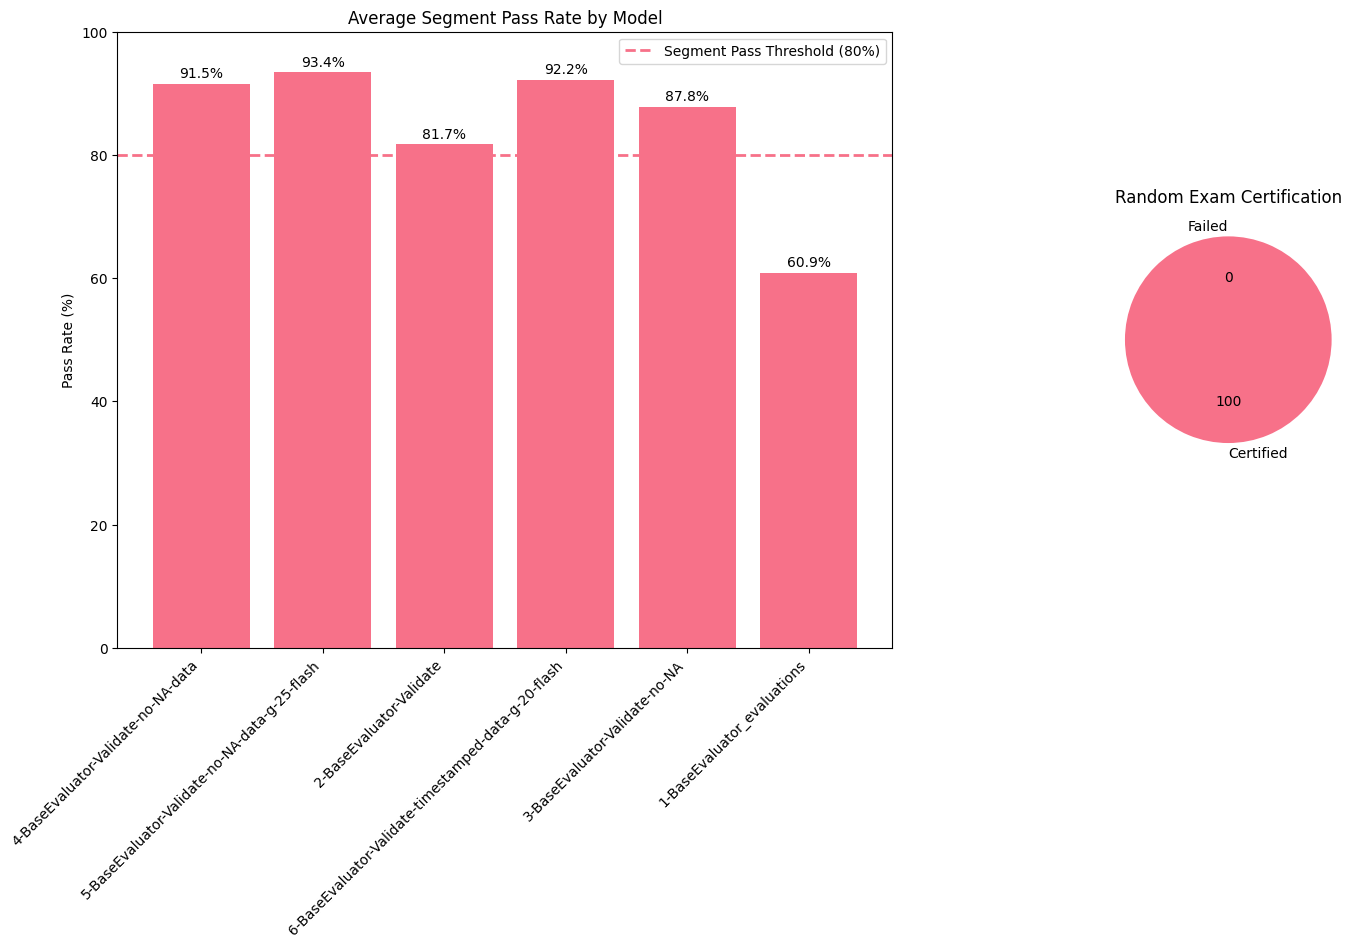


📈 Creating Performance Progression Chart...


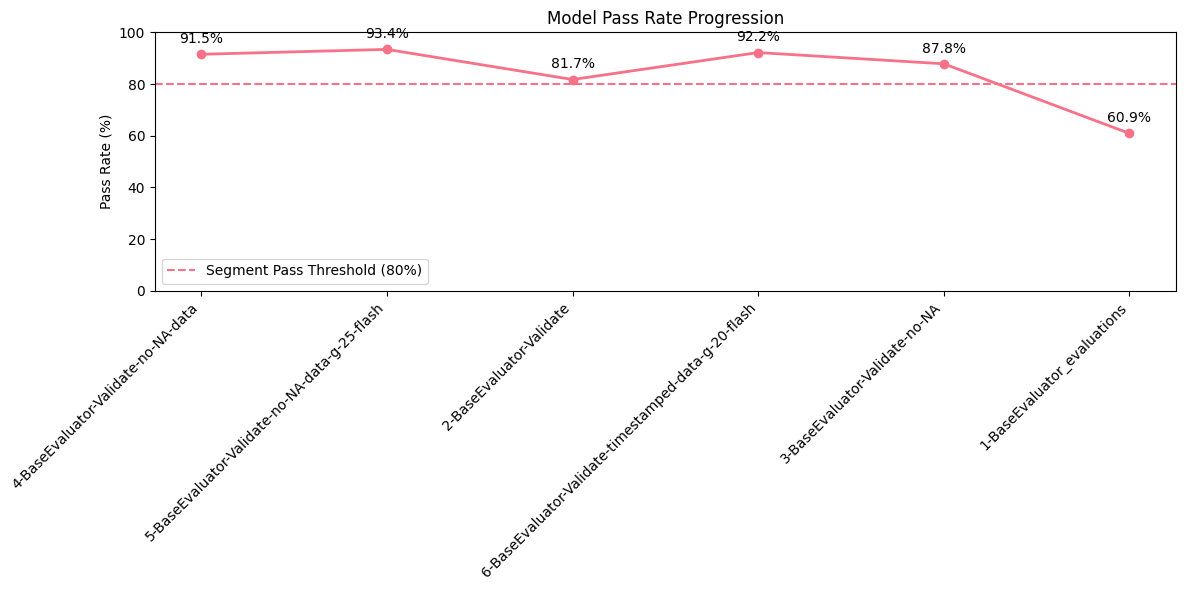


📋 Creating Detailed Metrics Table...


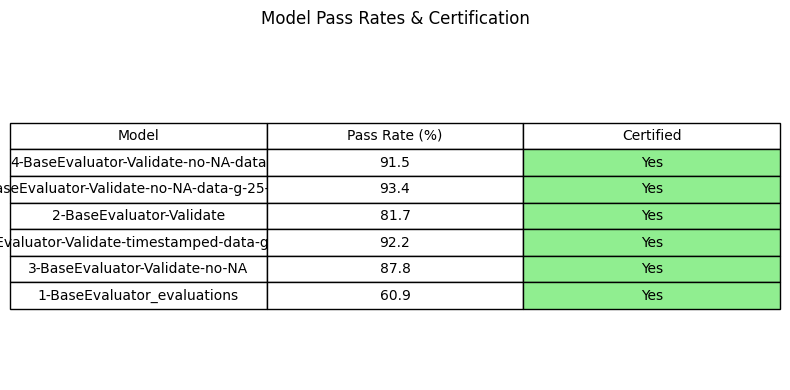


📊 Creating Element-Level Reliability Charts...


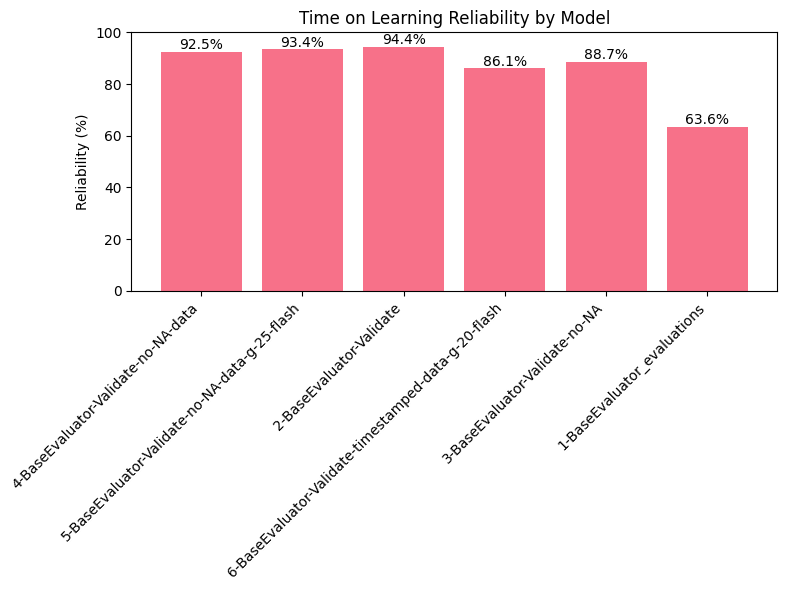

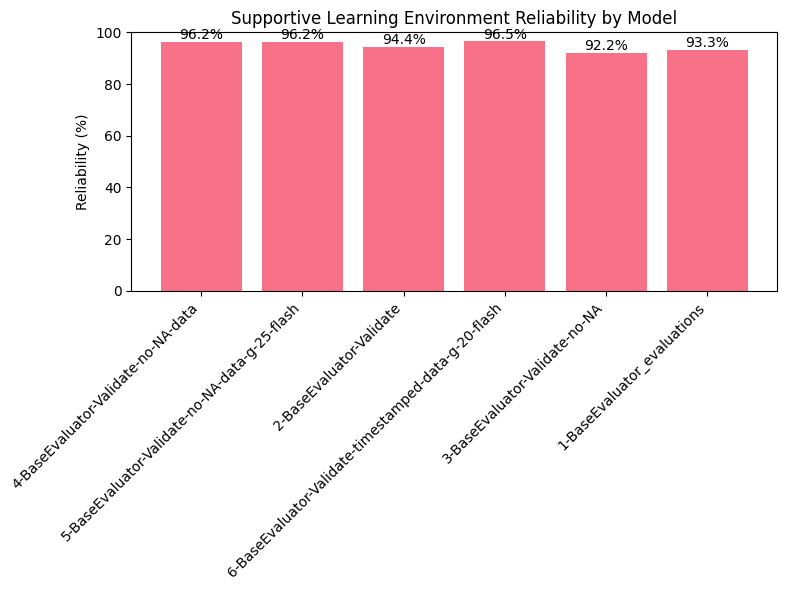

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


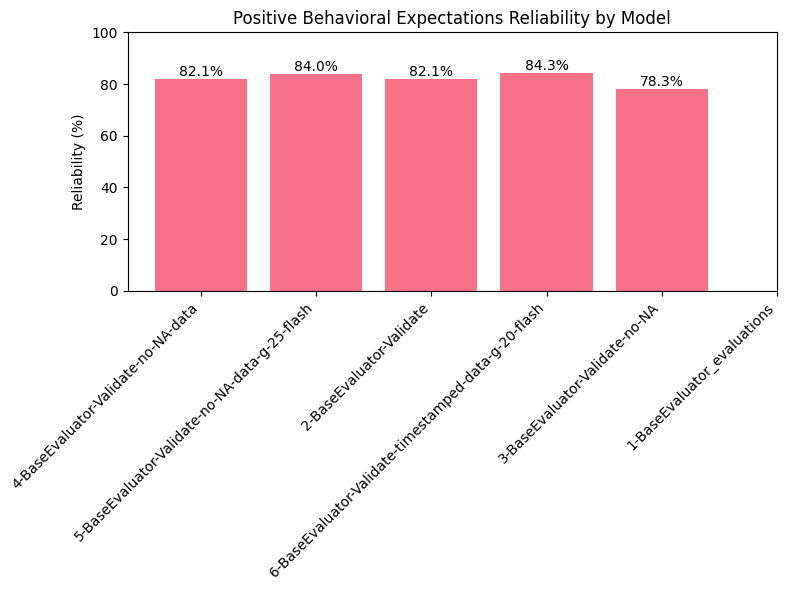

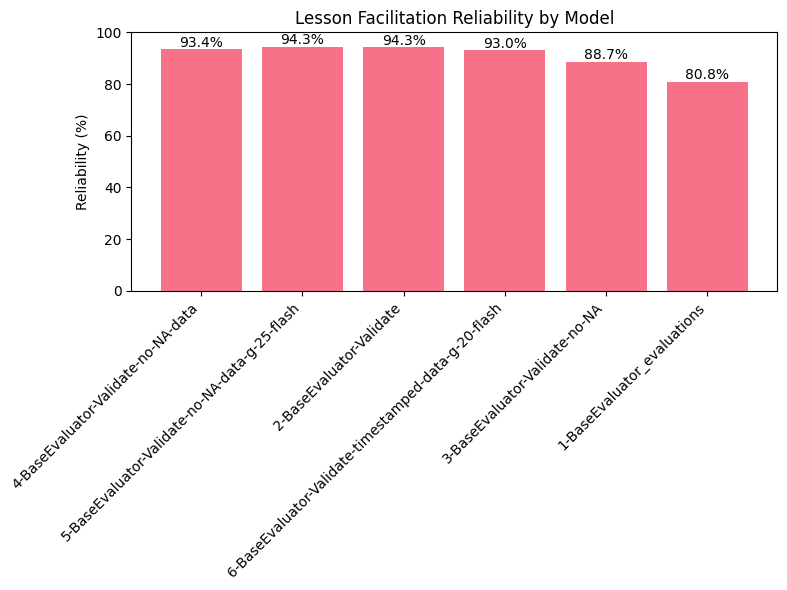

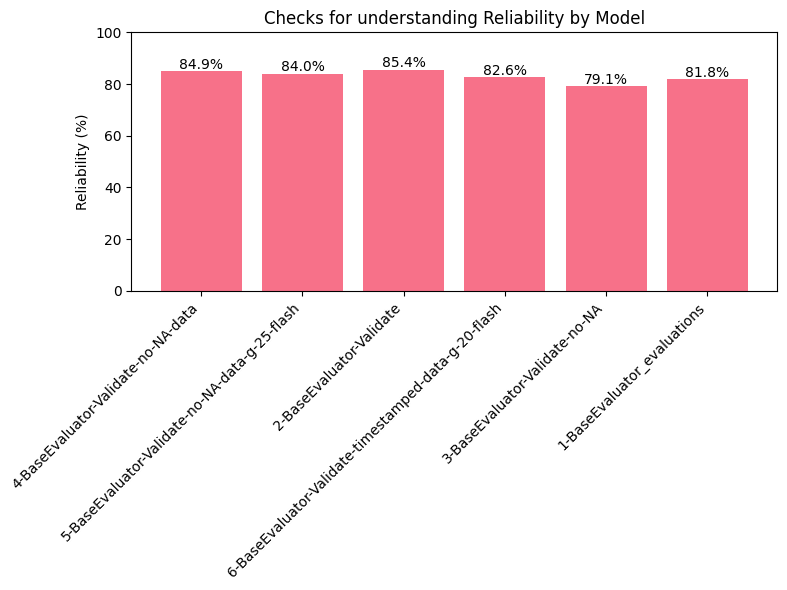

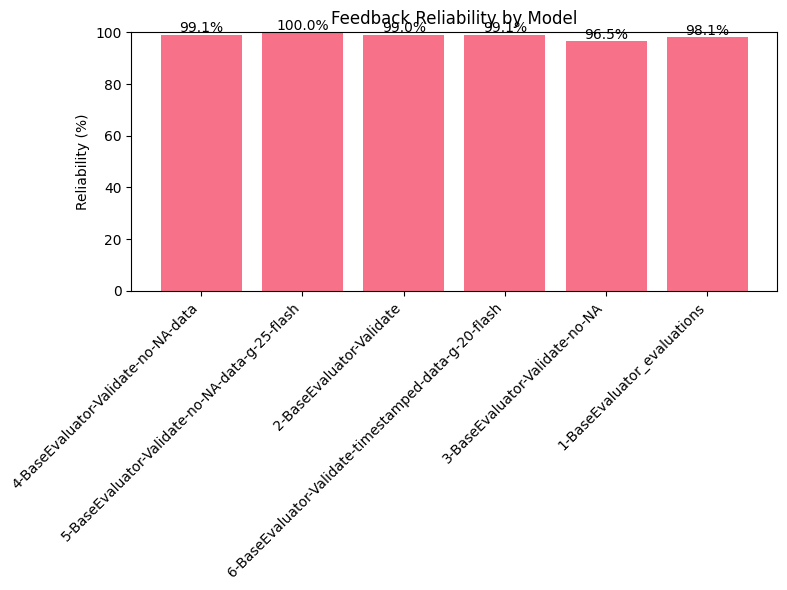

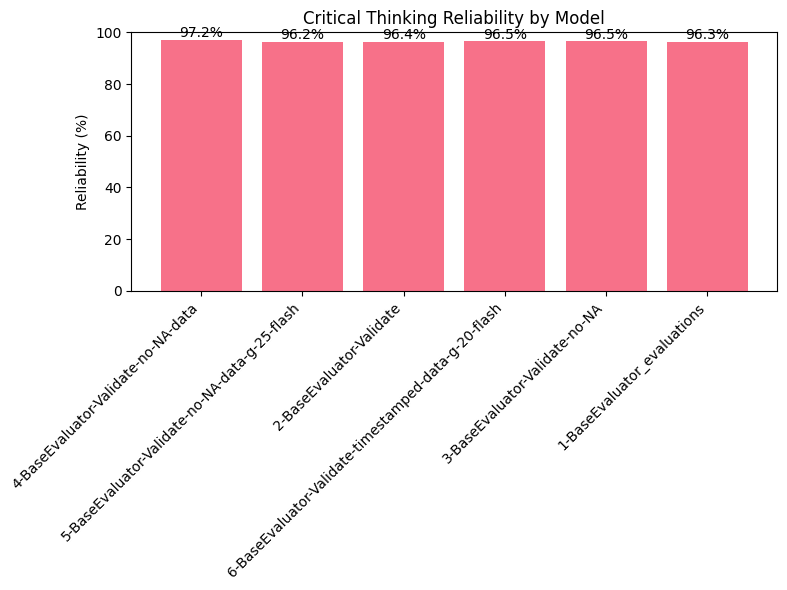

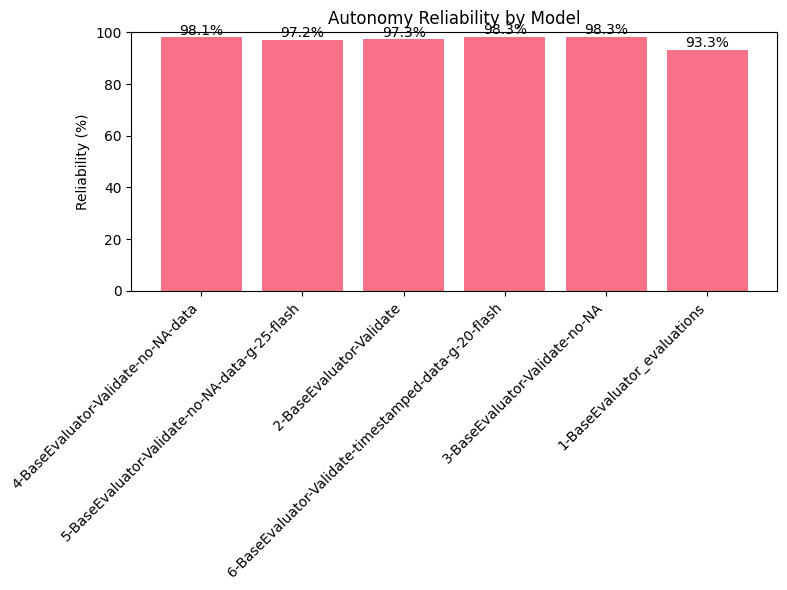

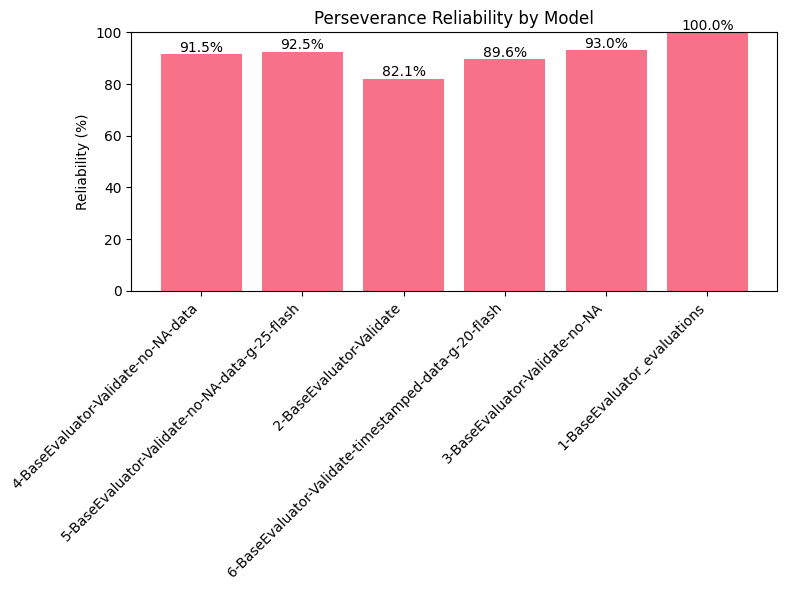

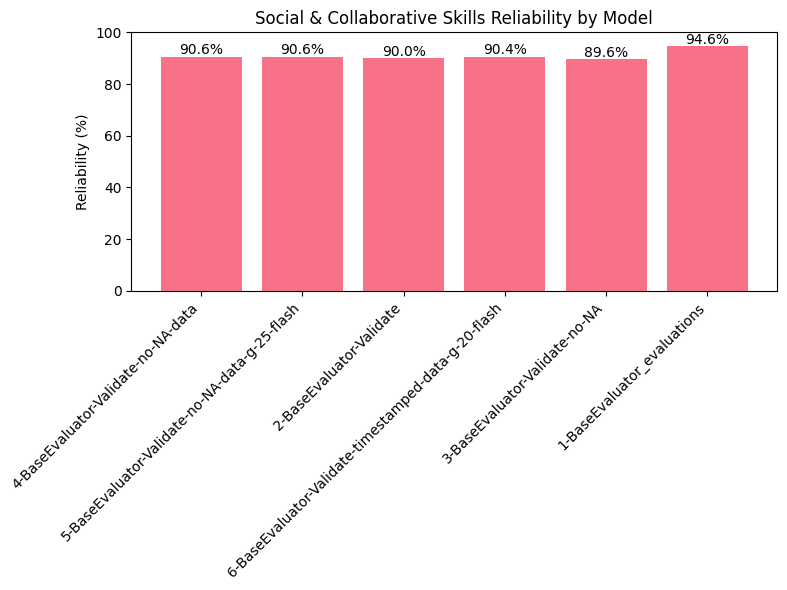

✅ Metrics CSV saved to: model_visualizations/model_performance_metrics.csv

🎉 All visualizations completed successfully!

📁 Visualizations saved to: model_visualizations
Files generated:
  - Autonomy_reliability.png
  - Checks_for_understanding_reliability.png
  - Critical_Thinking_reliability.png
  - Feedback_reliability.png
  - Lesson_Facilitation_reliability.png
  - Perseverance_reliability.png
  - Positive_Behavioral_Expectations_reliability.png
  - Social__Collaborative_Skills_reliability.png
  - Supportive_Learning_Environment_reliability.png
  - Time_on_Learning_reliability.png
  - detailed_metrics_table.png
  - exam_pass_rate.png
  - model_performance_metrics.csv
  - model_progression_chart.png
  - reliability_exam_dashboard.png
  - reliability_exam_summary.txt


In [ ]:
# (If you still want this as a separate “generate all” cell, you can either
#  remove duplication of data prep or simply call the exec cell again.
#  Here’s a streamlined version that assumes avg_results/random_results
#  already exist in the namespace.)

# 1. Main Performance Dashboard
print("\n📊 Creating Performance Dashboard...")
dashboard_path = os.path.join(VIZ_DIR, 'reliability_exam_dashboard.png')
fig_dashboard = create_exam_performance_dashboard(
    avg_results, random_results, save_path=dashboard_path
)

# 2. Performance Progression Chart
print("\n📈 Creating Performance Progression Chart...")
progression_path = os.path.join(VIZ_DIR, 'model_progression_chart.png')
fig_progression = create_performance_progression_chart(
    avg_results, save_path=progression_path
)

# 3. Detailed Metrics Table
print("\n📋 Creating Detailed Metrics Table...")
metrics_path = os.path.join(VIZ_DIR, 'detailed_metrics_table.png')
fig_table, metrics_df = create_detailed_metrics_table(
    avg_results, random_results, save_path=metrics_path
)

# 4. Element-Level Reliability Charts
print("\n📊 Creating Element-Level Reliability Charts...")
element_perf = compute_element_performance(
    models, ai_df_all, human_df_all,
    snapshot_teacher, snapshot_students, quality_elements
)
element_figs = create_element_performance_charts(
    element_perf, models, save_dir=VIZ_DIR
)

# 5. Save metrics as CSV for reference
csv_path = os.path.join(VIZ_DIR, 'model_performance_metrics.csv')
metrics_df.to_csv(csv_path, index=False)
print(f"✅ Metrics CSV saved to: {csv_path}")

print("\n🎉 All visualizations completed successfully!")
print(f"\n📁 Visualizations saved to: {VIZ_DIR}")
print("Files generated:")
for file in sorted(os.listdir(VIZ_DIR)):
    print(f"  - {file}")


## 10. Summary and Interpretation

Generate a comprehensive summary of the reliability exam results and provide interpretation guidance.

In [ ]:
def generate_comprehensive_summary(avg_results, random_results):
    """
    Generate a comprehensive text summary of the reliability exam results.
    """
    models = list(avg_results.keys())
    n_models = len(models)

    # Overall segment pass rates (%)
    pass_rates = [avg_results[model]['pass_rate'] * 100 for model in models]
    certified_count = sum(random_results[model]['certified'] for model in models)

    # Best and worst
    best_idx = np.argmax(pass_rates)
    worst_idx = np.argmin(pass_rates)
    avg_pass = np.mean(pass_rates)

    lines = []
    lines.append("🔍 RELIABILITY EXAM ANALYSIS SUMMARY")
    lines.append("=====================================")
    lines.append(f"\n📊 MODELS EVALUATED: {n_models}")
    lines.append(f"Models: {', '.join(models)}")
    lines.append(f"\n🎯 CERTIFICATION RESULTS:")
    lines.append(f"- Models Certified: {certified_count} of {n_models} "
                 f"({certified_count/n_models*100:.1f}%)")
    lines.append(f"- Models Failed: {n_models-certified_count} of {n_models} "
                 f"({(n_models-certified_count)/n_models*100:.1f}%)")
    lines.append(f"\n📈 PERFORMANCE BENCHMARKS:")
    lines.append(f"- Average Segment Pass Rate: {avg_pass:.1f}%")
    lines.append(f"- Best Model: {models[best_idx]} ({pass_rates[best_idx]:.1f}%)")
    lines.append(f"- Worst Model: {models[worst_idx]} ({pass_rates[worst_idx]:.1f}%)")

    # Recommendations or insights could be added here...

    return {
        'total_models': n_models,
        'certified_models': certified_count,
        'avg_pass_rate': avg_pass,
        'best_model': models[best_idx],
        'worst_model': models[worst_idx],
        'lines': lines
    }

# Generate comprehensive summary
summary_stats = generate_comprehensive_summary(avg_results, random_results)

# Save summary to file
summary_path = os.path.join(VIZ_DIR, 'reliability_exam_summary.txt')
with open(summary_path, 'w') as f:
    # Capture the printed output (simplified version)
    f.write(f"Reliability Exam Summary\n")
    for line in summary_stats['lines']:
        f.write(line + "\n")
    f.write(f"======================\n\n")
    f.write(f"Models Evaluated: {summary_stats['total_models']}\n")
    f.write(f"Models Certified: {summary_stats['certified_models']}\n")

print(f"\nReport generated successfully! ✅")


Report generated successfully! ✅
